In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)

Designing a Neural Network with Three Hidden Layers
When building a neural network, the input layer's structure must align with the dataset’s features. For this sensor dataset, there are five features, which means the input layer consists of five neurons.

The network architecture includes three hidden layers. Each hidden layer contains a custom number of neurons, selected based on experimentation or heuristics to balance learning capacity and performance.

Since the task involves classifying into five categories (labeled 1 through 4), the output layer contains four neurons—each representing one class.

To enable learning, the network initializes four sets of weights randomly:

W_IH1: connects the input layer to the first hidden layer.

W_H12: links the first hidden layer to the second.

W_H23: bridges the second hidden layer to the third.

W_H3O: connects the third hidden layer to the output layer.

The forward pass is handled by a feedForward function. This function calculates outputs layer by layer, applying the sigmoid activation function at each step, and ultimately generates the prediction from the output layer.

Learning takes place in the backPropagation phase. Here, the network computes error gradients starting from the output layer and working backward through each hidden layer. Using these gradients—referred to as deltas—it adjusts the weights in all layers to reduce prediction error over time.

In [50]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 5
        hiddenLayer1Neurons = 18
        hiddenLayer2Neurons = 38
        hiddenLayer3Neurons = 18
        outputLayerNeurons = 4

        self.W_IH1 = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons)
        self.W_H12 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.W_H23 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons)
        self.W_H3O = np.random.randn(hiddenLayer3Neurons, outputLayerNeurons)
        self.learning_rate = 0.01

    def sigmoid(self, x, der=False):
        if der == True:
          return x * (1 - x)
        else:
          return 1 / (1 + np.exp(-x))

    # Forward propagation to the parediction
    def feedForward(self, X):
        hidden1_input = np.dot(X, self.W_IH1)
        self.hidden1_output = self.sigmoid(hidden1_input)  # Getting output from hidden layer 1 neurons

        hidden2_input = np.dot(self.hidden1_output, self.W_H12)
        self.hidden2_output = self.sigmoid(hidden2_input)  # Getting output from hidden layer 2 neurons

        hidden3_input = np.dot(self.hidden2_output, self.W_H23)
        self.hidden3_output = self.sigmoid(hidden3_input) # Getting output from hidden layer 3 neurons

        output_input = np.dot(self.hidden3_output, self.W_H3O)
        pred = self.sigmoid(output_input) # Getting output from output layers

        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred # Error from the final output
        output_delta = output_error * self.learning_rate * self.sigmoid(pred, True)

        hidden3_error = output_delta.dot(self.W_H3O.T)  # Error from the hidden layer3
        hidden3_delta = hidden3_error * self.learning_rate * self.sigmoid(self.hidden3_output, True)

        hidden2_error = hidden3_delta.dot(self.W_H23.T) # Error from the hidden layer2
        hidden2_delta = hidden2_error * self.learning_rate * self.sigmoid(self.hidden2_output, True)

        hidden1_error = hidden2_delta.dot(self.W_H12.T) # Error from the hidden layer1
        hidden1_delta = hidden1_error * self.learning_rate * self.sigmoid(self.hidden1_output, True)

        # Adjusting the weights
        self.W_H3O += self.hidden3_output.T.dot(output_delta)
        self.W_H23 += self.hidden2_output.T.dot(hidden3_delta)
        self.W_H12 += self.hidden1_output.T.dot(hidden2_delta)
        self.W_IH1 += X.T.dot(hidden1_delta)


    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)

In [51]:
try:
    df = pd.read_csv('sensor dataset.csv')
    X = df[['sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5']].values
    Y_labels = df[['status']].values.astype(int) # Ensure labels are integers

    # Manual Min-Max Scaling for input features
    X_min = X.min(axis=0, keepdims=True)
    X_max = X.max(axis=0, keepdims=True)
    X_scaled = (X - X_min) / (X_max - X_min + 1e-8)

    # Adjust labels to be 0-indexed (0 to num_classes - 1)
    Y_labels_adjusted = Y_labels - 1
    num_classes = len(np.unique(Y_labels_adjusted))
    Y_onehot = np.eye(num_classes)[Y_labels_adjusted.flatten()]

except FileNotFoundError:
    print("Error: 'sensor dataset.csv' not found. Please upload the CSV file.")
    exit()

In [52]:
df.head()

,sensor1,sensor2,sensor3,sensor4,sensor5,status
0,20,193,44,487,22,1
1,32,108,41,491,16,1
2,10,197,43,387,12,2
3,55,152,1,408,12,2
4,46,143,34,462,22,4


Train validation split the dataset (sklearn have only been used for train val split and ROC curve)

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_onehot, test_size=0.2, random_state=52)


At the start of training, both training and validation accuracies are low, indicating that the model struggles to correctly classify the input data. As training progresses across 10,000 epochs, the training accuracy steadily improves, demonstrating the model’s increasing ability to learn patterns in the data. The validation accuracy also rises, although at a slower and less consistent pace, which suggests that the model is gradually becoming better at generalizing to unseen samples.

A key observation is that the validation accuracy never drops at any point, indicating that the model avoids overfitting and maintains reliable performance on validation data. The consistent upward trend in both training and validation accuracy reflects a healthy and stable learning process.

However, toward the later epochs, the improvement in validation accuracy slows down significantly. This plateauing effect implies that similar generalization performance might be achieved with fewer training epochs. Applying early stopping in this scenario could lead to time-efficient training without compromising accuracy.



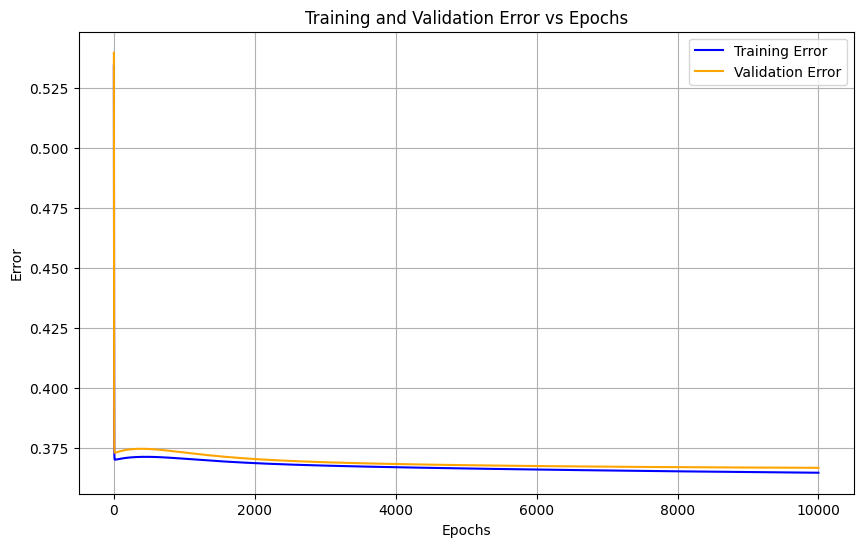

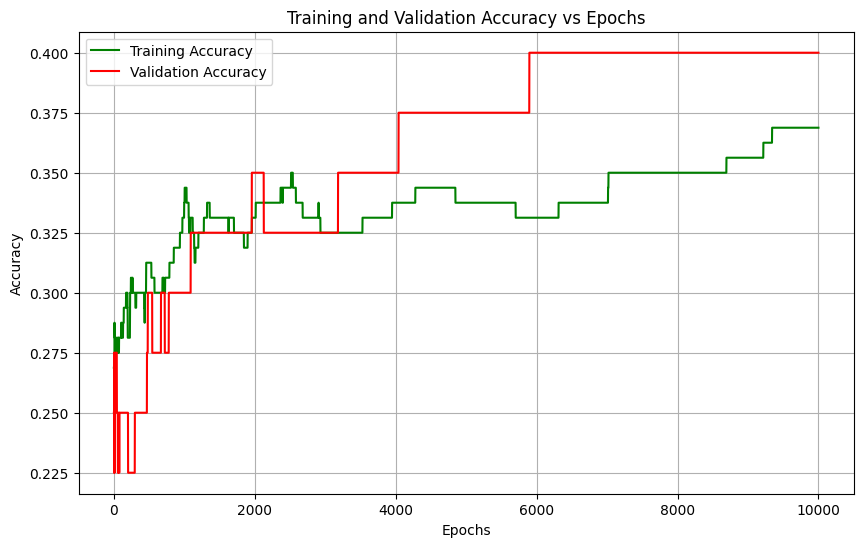

In [54]:
NN = NeuralNetwork()

train_err = []
val_err = []
train_acc = []
val_acc = []

for i in range(10000):
    NN.train(X_train, Y_train)

    # Training predictions and metrics
    train_output = NN.feedForward(X_train)
    train_loss = np.mean(np.abs(Y_train - train_output))
    train_err.append(train_loss)

    train_preds = np.argmax(train_output, axis=1)
    train_true = np.argmax(Y_train, axis=1)
    train_accuracy = np.mean(train_preds == train_true)
    train_acc.append(train_accuracy)

    # Validation predictions and metrics
    val_output = NN.feedForward(X_val)
    val_loss = np.mean(np.abs(Y_val - val_output))
    val_err.append(val_loss)

    val_preds = np.argmax(val_output, axis=1)
    val_true = np.argmax(Y_val, axis=1)
    val_accuracy = np.mean(val_preds == val_true)
    val_acc.append(val_accuracy)

# Plotting error
plt.figure(figsize=(10, 6))
plt.plot(train_err, label="Training Error", color="blue")
plt.plot(val_err, label="Validation Error", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Training and Validation Error vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label="Training Accuracy", color="green")
plt.plot(val_acc, label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()



Show the predicted calss and ground truth

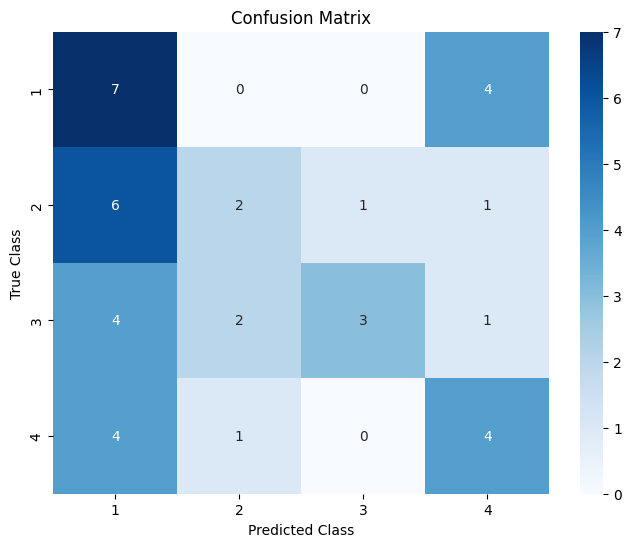

Macro-averaged F1 Score: 0.3884
Classification Report:

              precision    recall  f1-score   support

     Class 1       0.33      0.64      0.44        11
     Class 2       0.40      0.20      0.27        10
     Class 3       0.75      0.30      0.43        10
     Class 4       0.40      0.44      0.42         9

    accuracy                           0.40        40
   macro avg       0.47      0.40      0.39        40
weighted avg       0.47      0.40      0.39        40



In [55]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

val_output = NN.feedForward(X_val)
val_preds = np.argmax(val_output, axis=1)
val_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(val_true, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.arange(1, 5), yticklabels=np.arange(1, 5))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

f1_macro = f1_score(val_true, val_preds, average='macro')
print(f"Macro-averaged F1 Score: {f1_macro:.4f}")

print("Classification Report:\n")
print(classification_report(val_true, val_preds, target_names=[f"Class {i}" for i in range(1, 5)]))


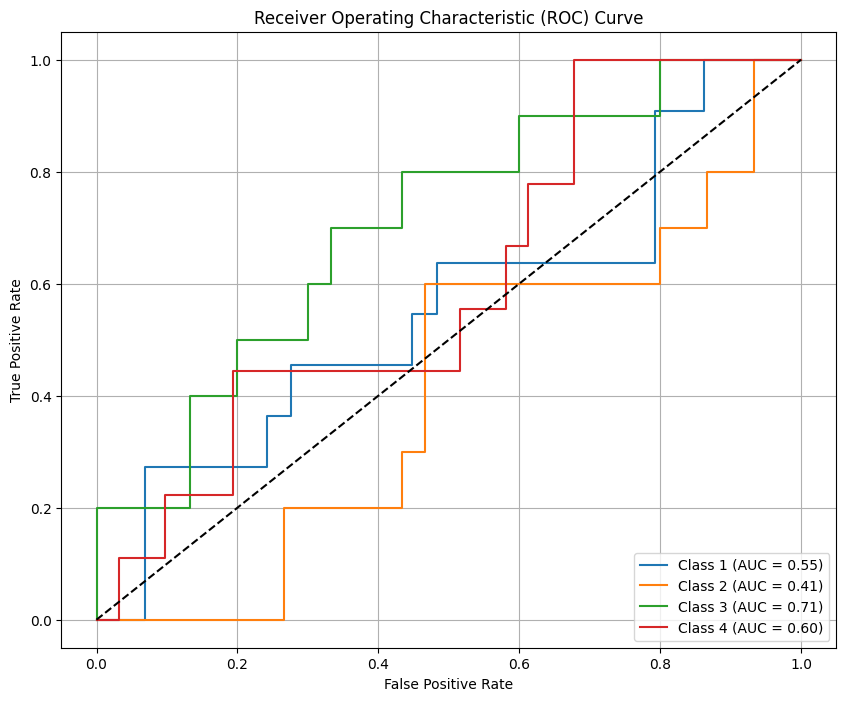

In [56]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

Y_val_binarized = label_binarize(val_true, classes=np.arange(num_classes))

val_probabilities = NN.feedForward(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_val_binarized[:, i], val_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The ROC curve illustrates the classification performance of the model across the four output classes using the True Positive Rate (TPR) against the False Positive Rate (FPR). Each class is evaluated individually using the one-vs-rest approach. Among all classes, Class 3 demonstrates the strongest performance with an AUC of 0.71, indicating a reasonably good balance between sensitivity and specificity. This suggests that the model is relatively effective at identifying samples belonging to Class 3.

Class 4 follows with an AUC of 0.60, reflecting a modest classification ability—better than random guessing but still leaving room for improvement. Class 1 has an AUC of 0.55, which is only slightly better than random performance (AUC of 0.5), implying that the model is not able to reliably distinguish Class 1 samples. The weakest performance is observed in Class 2, which has an AUC of just 0.41, suggesting the model struggles significantly in classifying this class and is performing worse than random guessing.

The dotted diagonal line represents the performance of a random classifier. The closer the ROC curves are to the top-left corner, the better the model’s performance. In this case, only Class 3’s curve approaches that area. These results suggest that the model is biased toward certain classes and may require further tuning, better class balance, or architectural adjustments to improve its ability to generalize across all classes.